# Projekt zaliczeniowy - SiAD w Python (studia podyplomowe) <br>
**Analiza ryzyka opóźnień lotniczych, symulacja scenariuszy zakupowych optymalizujacych zysk z odszkodowań**

*Notatnik dostosowany do trybu ciemnego
***

<a id="cel"></a>
## Cel analizy:
* Budowa i walidacja **biznesowego modelu decyzyjnego**, który minimalizuje ryzyko inwestycyjne, jednocześnie maksymalizując oczekiwany zysk i zwrot (*ROI*) z zakupu biletów lotniczych (odszkodowania za opóźnienie)<br><br>
* **Predykcja szansy**: Oszacowanie, z wykorzystaniem danych czasowych i operacyjnych, prawdopodobieństwa wystąpienia opóźnienia lotu kwalifikującego do odszkodowania (`delay` $\ge 3$h z winy przewoźnika)<br><br>
* **Strategia**: Wyznaczenie optymalnego progu pewności modelu (punktu odcięcia), który gwarantuje najwyższą rentowność w symulowanym portfelu klienta dla przyjętego poziomu cen.<br><br>
* **Wnioski**: Wskazanie potencjalnej luki prawnej w badanym obszarze.

<img src="https://raw.githubusercontent.com/jonaszszpoton/flight_delay_gambling/5bae1ab22d8fb90f7d7ec38358e42d7f76517ea3/diagram%20(1).svg" width="1000">

## Spis treści:

1. [Cel analizy](#cel)<br>
2. [Generowanie danych](#gen)<br>
3. [Budowa i walidacja modelu](#mod)<br>
2. [Tworzenie symulacji biznesowej](#sym)<br>
3. [Wnioski](#wn)<br>

<a id="gen"></a>
## Generowanie danych:
***

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

rows = 50000 #50 tys. unikalnych rekordów (lotów) 

Funkcja pomocnicza do normalizacji wag losowań do prawdopodobieństw z suma 1.0:

In [3]:
def norm_prob(probs):
    p = np.array(probs)
    return p / p.sum()

**1.1. Trasy** (kolumny: origin, destination, distance, airline, plane)

In [4]:
np.random.seed(123) 

# wszystkie trasy min. 1 lotnisko w UE (wymóg prawny do odszkodowania)

routes = [
    # PL - EU
    ('WAW', 'CDG', 1370, 'LOT', 'Embraer 195'),
    ('WAW', 'BRU', 1140, 'LOT', 'Boeing 737-800'),
    ('WAW', 'MAD', 2290, 'LOT', 'Boeing 737-800'),
    ('KRK', 'BGY', 950, 'Ryanair', 'Boeing 737-8200'),
    ('GDN', 'ARN', 640, 'Wizz Air', 'Airbus A321'),
    ('KRK', 'MUC', 620, 'Lufthansa', 'Airbus A319'),
    ('WRO', 'VIE', 360, 'LOT', 'Embraer 170'),
    ('WAW', 'BCN', 2000, 'Wizz Air', 'Airbus A321'),
    ('WAW', 'PRG', 520, 'LOT', 'Embraer 170'),
    ('KRK', 'ZAD', 700, 'Ryanair', 'Boeing 737-800'),
    ('KRK', 'DUB', 1900, 'Ryanair', 'Boeing 737-800'),
    ('WAW', 'FCO', 1330, 'LOT', 'Boeing 737-800'),
    ('GDN', 'HAM', 600, 'Wizz Air', 'Airbus A320'),
    ('POZ', 'TSF', 900, 'Ryanair', 'Boeing 737-800'),
    ('RZE', 'DUS', 1100, 'LOT', 'Embraer 170'),
    ('WMI', 'ALC', 2280, 'Ryanair', 'Boeing 737-800'), 

    # EU - EU
    ('FRA', 'VIE', 480, 'Lufthansa', 'Airbus A320'),
    ('FRA', 'FCO', 960, 'Lufthansa', 'Airbus A320'),
    ('AMS', 'LIS', 1860, 'KLM', 'Boeing 737-800'),
    ('CDG', 'ATH', 2090, 'Air France', 'Airbus A321'),
    ('MAD', 'BUD', 2070, 'Iberia', 'Airbus A320'),
    ('FCO', 'DUB', 1900, 'Aer Lingus', 'Airbus A320'),
    ('CDG', 'LIS', 1450, 'Air France', 'Airbus A320'),
    ('MUC', 'HAM', 600, 'Lufthansa', 'Airbus A319'),
    ('BCN', 'NAP', 1000, 'Vueling', 'Airbus A320'),
    ('AMS', 'PRG', 710, 'KLM', 'Embraer 190'),
    ('MAD', 'AGP', 420, 'Iberia', 'Airbus A320'),
    ('VIE', 'BER', 520, 'Austrian Airlines', 'DH8D'),
    ('CPH', 'HEL', 890, 'Finnair', 'Airbus A321'),
    ('ATH', 'FCO', 1050, 'Aegean', 'Airbus A320'),
    ('DUS', 'PMI', 1500, 'Eurowings', 'Airbus A320'),
    ('BRU', 'BCN', 1100, 'Brussels Airlines', 'Airbus A319'),
    ('LIS', 'VCE', 1700, 'TAP Portugal', 'Airbus A320'),
    ('FCO', 'OPO', 1800, 'Ryanair', 'Boeing 737-800'),
    ('CDG', 'MUC', 680, 'Air France', 'Embraer 190'),
    ('VIE', 'SKG', 780, 'Austrian Airlines', 'Embraer 195'),
    ('MAD', 'VLL', 170, 'Iberia', 'ATR 72'),
    ('AMS', 'MLA', 2050, 'KLM', 'Boeing 737-900'),
    ('MUC', 'ATH', 1500, 'Lufthansa', 'Airbus A321'),

    # EU - inne
    ('DXB', 'WAW', 4200, 'Emirates', 'Boeing 777-300ER'),
    ('DOH', 'CDG', 4900, 'Qatar Airways', 'Airbus A380'),
    ('IST', 'BER', 1650, 'Turkish Airlines', 'Airbus A321'),
    ('JFK', 'FRA', 6200, 'Delta', 'Airbus A330'),
    ('ZRH', 'WAW', 1050, 'Swiss International Air Lines', 'Airbus A220'),
    ('CDG', 'PEK', 8200, 'Air France', 'Boeing 777-300ER'),
    ('FRA', 'EWR', 6180, 'Lufthansa', 'Airbus A340-600'),
    ('AMS', 'GRU', 9780, 'KLM', 'Boeing 787-9'),
    ('MAD', 'MEX', 9000, 'Iberia', 'Airbus A350-900'),
    ('WAW', 'ICN', 7100, 'LOT', 'Boeing 787-8'),
    ('MUC', 'BKK', 8600, 'Lufthansa', 'Airbus A350-900'),
    ('VIE', 'TLV', 2000, 'Austrian Airlines', 'Boeing 737-800'),
    ('WAW', 'LHR', 1450, 'LOT', 'Boeing 737-800'),       
    ('KRK', 'EDI', 1700, 'Ryanair', 'Boeing 737-800'),   
    ('DUB', 'LGW', 460, 'Aer Lingus', 'Airbus A320'),    
    ('GDN', 'OSL', 770, 'Wizz Air', 'Airbus A320'),    
    ('CDG', 'YUL', 5500, 'Air France', 'Boeing 787-9'),
    ('FCO', 'MIA', 8200, 'ITA Airways', 'Airbus A330neo'),
    ('FRA', 'CPT', 9300, 'Lufthansa', 'Boeing 747-8'),
    ('AMS', 'DXB', 5200, 'KLM', 'Boeing 777-200ER'),
    ('MAD', 'SCL', 10700, 'Iberia', 'Airbus A350-900'),
    ('WAW', 'ORD', 7500, 'LOT', 'Boeing 787-9'),
    ('VIE', 'NRT', 9100, 'Austrian Airlines', 'Boeing 787-9'),
    ('BRU', 'YYZ', 6200, 'Air Canada', 'Boeing 787-8'),
]

sched_durations = [155, 136, 198, 121, 96, 95, 74, 185, 87, 101, 197, 151, 93, 117, 133, 197, 
79, 122, 169, 184, 181, 177, 151, 93, 125, 102, 78, 87, 116, 131, 165, 138, 
181, 189, 99, 107, 59, 182, 165, 325, 372, 177, 458, 129, 592, 457, 697, 645, 
518, 618, 185, 156, 177, 82, 106, 412, 592, 665, 392, 758, 545, 653, 458] #planowe czasy trwania kolejnych lotów

routes_with_durations = []
for route, duration in zip(routes, sched_durations): #dołaczenie kolumny z planowym czasem lotu 
    route_with_duration = route + (duration,)
    routes_with_durations.append(route_with_duration)

# częstotliwość tras 
route_weights = norm_prob(np.random.rand(len(routes_with_durations)))
route_indices = np.random.choice(len(routes_with_durations), rows, p=route_weights) # losowanie indeksu trasy z prawdopodobieństwem route_weights
data_routes = [routes_with_durations[i] for i in route_indices] # parowanie wylosowanych indeksów z odpowiadajaca mu trasa
df = pd.DataFrame(data_routes, 
                  columns=['origin', 'dest', 'dist_km', 'airline', 'plane', 'sched_duration'])


**1.2. Kod lotu:**<br>
Dla linii bez 'AIR' jako pierwsze słowo w nazwie: pierwsze 2 litery nazwy + liczba losowa<br>
Dla linii z 'AIR': A + pierwsza litera z drugiego członu + liczba losowa<br>
Cel: uniknięcie powtórzeń w kodach dla różnych linii.

In [5]:
df['flight_code'] = ['A' + df['airline'][i].split()[1][:1] + str(np.random.randint(100, 999))
                     if df['airline'][i].split()[0].upper() == 'AIR' else df['airline'][i][:2].upper() + str(np.random.randint(100, 999)) 
                     for i in range(len(df))]

**1.3. Data i czas lotu:**<br>
Start okresu symulacji przyjmuję 1.1.2020, koniec 31.10.2025

In [6]:
# kalendarz dat odlotów
start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 10, 31)
total_days = (end_date - start_date).days

dep_offset = np.random.randint(0, total_days + 1, size=rows) # losowanie dnia odlotu od daty startowej
dep_dates = np.array([start_date + timedelta(days=int(day_number)) for day_number in dep_offset]) # tworzenie kalendarza odlotów

hours_weights = norm_prob([0.005, 0.005, 0.0005, 0.0001, 0.001, 0.05, 0.08, 0.09, 0.08, 0.06, 0.05, 0.05, 0.05, 0.05, 0.06, 0.07,
                  0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01, 0.005]) # uwzględniam godziny szczytu

dep_hours = np.random.choice(np.arange(24), size=rows, p=hours_weights) # losowanie obciażne godziny odlotu (0-23)
dep_minutes = np.random.choice([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], size=rows) # losowanie minuty odlotu

# łaczenie wylosowanych dat, godzin i minut odlotów w jedna zmienna departures
departures = zip(dep_dates, dep_hours, dep_minutes)

In [7]:
# tworzenie kolumny z data odlotu
df['sched_dep_time'] = [pd.Timestamp(date.year, date.month, date.day, hour, minute) for date, hour, minute in departures] 
df.sort_values('sched_dep_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# tworzenie pozostałych kolumn
df['sched_dep_year'] = df['sched_dep_time'].dt.year
df['sched_dep_month'] = df['sched_dep_time'].dt.month
df['sched_dep_day_of_week'] = df['sched_dep_time'].dt.day_of_week + 1 
df['sched_dep_hour'] = df['sched_dep_time'].dt.hour
df['sched_arr_time'] = df['sched_dep_time'] + pd.to_timedelta(df['sched_duration'], unit='m')

**1.4. Pogoda**:<br>
Zmienna pogody będzie wpływać na prawdopodobieństwo opóźnienia

In [8]:
weather_types = ['Clear', 'Cloudy', 'Rain', 'Fog', 'Snow', 'Storm']

weather_type = []
weather_intensity = []

for month in df['sched_dep_month']:
    if month in [12, 1, 2]:  # zima
        p_weather_type = norm_prob([0.10, 0.25, 0.20, 0.15, 0.20, 0.10])
        weather_intensisty_rate = 1.0
    elif month in [6, 7, 8]:  # lato
        p_weather_type = norm_prob([0.5, 0.2, 0.10, 0.05, 0.00, 0.15])
        weather_intensisty_rate = 0.7
    else:  # wiosna/jesień
        p_weather_type = norm_prob([0.29, 0.30, 0.25, 0.10, 0.01, 0.05])
        weather_intensisty_rate = 0.6
        
    weather_type.append(np.random.choice(weather_types, p=p_weather_type))
    weather_intensity.append(np.random.rand()*weather_intensisty_rate)
    

df['weather_origin'] = weather_type
df['weather_intensity'] = weather_intensity

**1.5. Opóźnienie na wylocie**:

$$
P(\text{delay}) = \min \left( 0.95, \quad \max \left( 0, \quad P_{\text{base}} + F_{\text{weather}} + F_{\text{time}} + F_{\text{season}} +  F_{\text{day}}\right) \right)
$$

In [9]:
base_delay_prob = 0.2 # bazowe prawdopodobieństwo

# wpływ czynników na prawdopodobieństwo opóźnienia

# pogoda
weather_factor = np.select([df['weather_origin'].isin(['Fog', 'Snow', 'Storm']), df['weather_origin'] == 'Rain', df['weather_origin'] == 'Cloudy'],
                           [0.3*df['weather_intensity'], 0.1*df['weather_intensity'], 0.05*df['weather_intensity']], default = 0.0)

# pora dnia
time_factor = (df['sched_dep_hour'] - 6) * 0.02 # wprowadzam dziedziczenie (wzrost p) opóźnień w miarę upływu dnia od godz. 6 
time_factor = np.select([df['sched_dep_hour'].isin([0,1]), df['sched_dep_hour']==2], [0.4, 0.2], default = time_factor) # nocne godziny (po 23)
time_factor = np.where(time_factor < 0.0, 0.0, time_factor) #wyzerowanie ujemnych wpływów (3:00-5:00)

# okres w roku
season_factor = np.select([df['sched_dep_month'].isin([7, 8, 12, 1]), df['sched_dep_month'].isin([6,9])], [0.1, 0.07], default = 0.0)  # okresy szczytu

# dzień tygodnia
day_factor = np.select([df['sched_dep_day_of_week'].isin([5,6,7]),df['sched_dep_day_of_week'].isin([3,4])], [0.25,0.1], default = 0.0)

delay_prob = (base_delay_prob + weather_factor + time_factor + season_factor + day_factor).clip(0, 0.95) # min. p = 0, max. p = 0.99
delay_mark = np.random.rand(rows) < delay_prob # losowanie, czy lot jest opóźniony zgodnie z P(delay_prob)

In [10]:
from collections import Counter

items = Counter(delay_mark).keys()
count = Counter(delay_mark).values()

print(items,'\n', count) # sprawdzam proporcję opóźnień

dict_keys([np.False_, np.True_]) 
 dict_values([22244, 27756])


**1.6. Czas odlotu/opóźnienia**:<br>
Losowanie faktycznego czasu odlotu w minutach. Dla opóźnionych losowanie z rozkładu Gamma (skala dynamiczna zależna od sezonu i pogody, *min=15*), dla niepóźnonych ucięty rozkład normalny z *sd=5* i *min_val=0* (niewielkie wahania w nieujemnym zakresie).

In [11]:
# hiperparamtery rozkładu opóźnień (Gamma)
shape = 2.5
scale = 25.0
min_delay = 15

Prosty wykres gęstości do doboru hiperparametrów rozkładu opóźnień (Gamma):

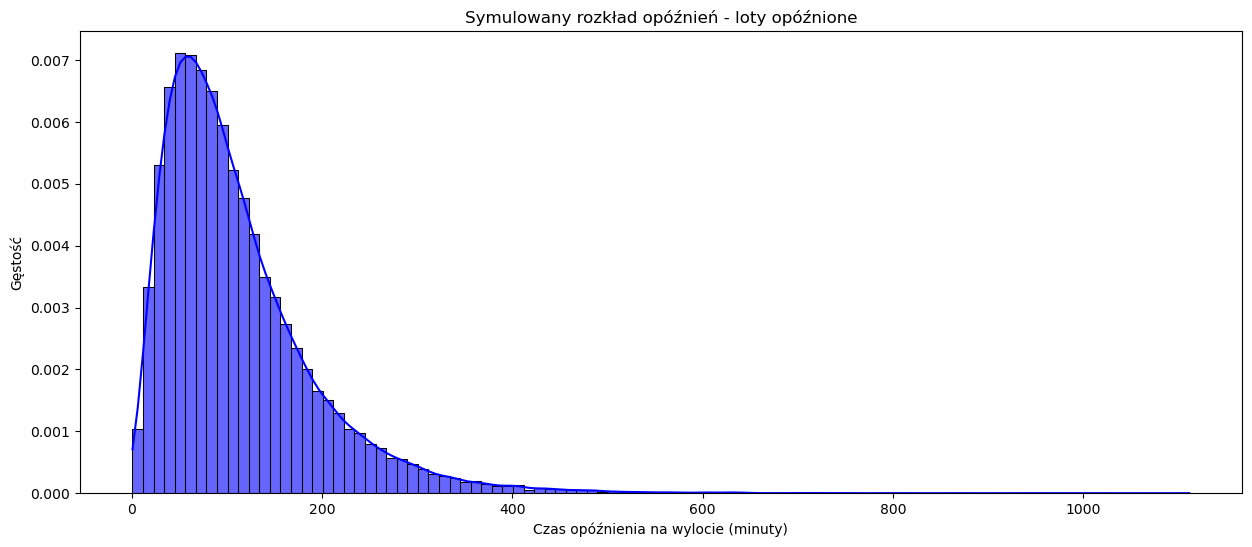

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

delay_lengths = np.select(
    [df['sched_dep_month'].isin([12, 1, 2]),    
        df['sched_dep_month'].isin([7, 8])        
    ],
    [1.4, 1.15],
    default=1.0
)

weather = 1 + (df['weather_intensity'] * 0.5) 

hour = 1 + np.select([df['sched_dep_hour'].isin([8,9,16,17,18,19]), df['sched_dep_hour'].isin([10,14,15,20,21])], [0.35, 0.15], default=0.0) # godziny szczytu

dow = 1 + np.select([df['sched_dep_day_of_week'].isin([5, 7]), df['sched_dep_day_of_week'] == 6], [0.4, 0.15], default=0.0)


d_scale = scale * delay_lengths * weather * hour * dow

delays_gamma = np.random.gamma(shape, d_scale, rows) # dynamiczny rozkład opóźnienia (zależny od sezonu, godziny, dnia tygodnia i pogody)

dep_delay_minutes = np.where(
    delay_mark,
    delays_gamma + min_delay,           
    np.random.normal(0, 5, rows).clip(0) 
).astype(int)

plt.figure(figsize=(15, 6))
sns.histplot(delays_gamma, bins=100, kde=True, 
             color='blue', stat='density', alpha=0.6)

plt.title('Symulowany rozkład opóźnień - loty opóźnione')
plt.xlabel('Czas opóźnienia na wylocie (minuty)')
plt.ylabel('Gęstość')
plt.show()

In [13]:
print(f'Średnia empiryczna: {delays_gamma.mean()} \nSD empiryczne: {delays_gamma.std()}')

Średnia empiryczna: 111.30083999172986 
SD empiryczne: 80.4245349681939


Tworzenie kolumn:

In [14]:
df['dep_delay'] = dep_delay_minutes
df['act_dep_time'] = df['sched_dep_time'] + pd.to_timedelta(df['dep_delay'], unit='m')

# wariancja 5% czasu lotu (możliwe nadrobienie niewielkiego opóźnienia w trakcie lotu lub pogłębienie opóźnienia)
air_time_variance = np.random.normal(0, df['sched_duration'] * 0.05, rows)
df['act_duration'] = (df['sched_duration'] + air_time_variance).astype(int)
df['act_arr_time'] = df['act_dep_time'] + pd.to_timedelta(df['act_duration'], unit='m')

# finalne opóźnienie na przylocie (min)
df['delay_minutes'] = ((df['act_arr_time'] - df['sched_arr_time']).dt.total_seconds() / 60).astype(int)

df['delay_3h'] = df['delay_minutes'] >= 180 # opóźnienia >180 min

In [15]:
df['delay_3h'].value_counts() #sprawdzam proporcję opóźnien >= 3h

delay_3h
False    43984
True      6016
Name: count, dtype: int64

In [16]:
df2 = df.copy()
df2['delay>0_minutes'] = df2['delay_minutes'].apply(lambda x: 0 if x < 0 else x)

In [17]:
print(f'Średni czas przylotu względem planowego czasu przylotu (min): {df['delay_minutes'].mean()}. Mediana: {df['delay_minutes'].median()}\nŚredni czas opóźnienia: {df2['delay>0_minutes'].mean()}')

Średni czas przylotu względem planowego czasu przylotu (min): 73.35394. Mediana: 48.0
Średni czas opóźnienia: 75.4992


In [18]:
delay_ratio = (len(df[df['dep_delay']>5])) / len(df) 
delay_ratio_15 = (len(df[df['dep_delay']>=15])) / len(df) 
print(f'Procent lotów opóźnionych o co najmniej 15 minut: {delay_ratio_15}')
print(f'Procent lotów opóźnionych o co najmniej 5 minut: {delay_ratio}')

Procent lotów opóźnionych o co najmniej 15 minut: 0.55556
Procent lotów opóźnionych o co najmniej 5 minut: 0.60676


**1.7. Przyczyna opóźnienia**:<br>
Dla uproszczenia dzielę tylko na dwie kategorie: z winy przewoźnika albo nadzwyczajne okoliczności.

In [19]:
random_draw = np.random.rand(rows) #stała seria losowa do porównań

# warunki:
c_no_delay = (df['delay_minutes'] <= 15)
c_heavy_weather = ((df['delay_minutes'] > 15) & (df['weather_origin'].isin(['Snow', 'Fog', 'Storm']))) #b. trudna pogoda = większe P(Extraordinary)
c_bad_weather = ((df['delay_minutes'] > 15) & (df['weather_origin'].isin(['Rain', 'Cloudy']))) # trudna pogoda = umiarkowane P(Extraordinary)
c_good_weather = (df['delay_minutes'] > 15) & (df['weather_origin'] == 'Clear') # dobra pogoda P(Extraordinary) stałe, niskie

df['delay_reason'] = 'Carrier Fault' # domyślnie

# dynamiczne progi P(Extraordinary) w zależności od typu i intensywności pogody:
p_heavy_weather = 0.2 + (df['weather_intensity'] / 2) # P(Extraordinary) od 0.1 do 0.6
p_bad_weather = 0.1 + (df['weather_intensity'] / 3) # P(Extraordinary) od 0.05 do 0.37

# losowanie dla b. złej pogody:
df['delay_reason'] = np.where(
    c_heavy_weather & (random_draw < p_heavy_weather),
    'Extraordinary',
    df['delay_reason']
)

# losowanie dla trudnej pogody:
df['delay_reason'] = np.where(
    c_bad_weather & (random_draw < p_bad_weather),
    'Extraordinary',
    df['delay_reason']
)

# losowanie dla dobrej pogody:
df['delay_reason'] = np.where(
    c_good_weather & (random_draw < 0.05), # P(Extraordinary) stałe 5%
    'Extraordinary',
    df['delay_reason']
)

# loty nieopóźnione: wypełnianie nan
df['delay_reason'] = np.where(
    c_no_delay,
    np.nan,
    df['delay_reason']
)

In [20]:
print(f'Liczba lotów opóźnionych o ponas 15 minut: {len(df[df['delay_minutes']>15])}')
print(f'Proporcje klas: {df['delay_reason'].value_counts()}')
print(f'Liczba lotów kwalifikujacych się do odszkodowania: {len(df[(df['delay_minutes']>=180) & (df['delay_reason'] == 'Carrier Fault')])}')
print(f'Procent lotów kwalifikujacych się do odszkodowania względem wszystkich lotów: {(len(df[(df['delay_minutes']>=180) & (df['delay_reason'] == 'Carrier Fault')]))/len(df)}')

Liczba lotów opóźnionych o ponas 15 minut: 30040
Proporcje klas: delay_reason
Carrier Fault    23264
Extraordinary     6776
Name: count, dtype: int64
Liczba lotów kwalifikujacych się do odszkodowania: 4351
Procent lotów kwalifikujacych się do odszkodowania względem wszystkich lotów: 0.08702


**1.8. Ceny lotów**:<br>
Ceny z uwzględnieniem inflacji.<br><br><center>
**Cena bazowa:**
</center>

$$\text{base\_price} = (50 + (\text{distance} \cdot \text{base\_rate})) \cdot F_{\text{airline}}$$
<br><center>
**Cena finalna:**
</center>

$$\text{price} = \max\left(15.0, \quad \text{base\_price} \cdot F_{\text{month}} \cdot F_{\text{day}} \cdot F_{\text{inflation}} \cdot F_{\text{variance}}\right)$$

In [21]:
base_rate = np.where(df['dist_km'] < 1500, 0.03, 0.025) # niższy mnożnik za kilometr dla długich lotów

airline_factor = np.where(df['airline'].isin(['Ryanair','Wizz Air','Vueling','TAP Portugal','Eurowings']), 0.6, 0.8) # niższe ceny dla linii budżetowych

base_price = (50 + (df['dist_km'] * base_rate)) * airline_factor

month_factor = np.select([df['sched_dep_month'].isin([7, 8, 12]), df['sched_dep_month'].isin([1, 2, 3, 10, 11])],[1.1, 0.85],default=1.0) # high i low season

day_factor = np.select([df['sched_dep_day_of_week'].isin([5, 6, 7]), df['sched_dep_day_of_week'].isin([2, 3])],[1.2,0.9],default=1.0) # weekend droższe, środek tyg. tańsze

inflation_index = {2020: 1.0, 2021: 1.03, 2022: 1.05, 2023: 1.06, 2024: 1.07, 2025: 1.09} # uwzględnienie inflacji 
inflation_factor = df['sched_dep_year'].map(inflation_index)

booking_variance = np.random.lognormal(0, 0.2, rows) #czynnik losowy

df['ticket_price_eur'] = (base_price * month_factor * day_factor * inflation_factor * booking_variance).clip(
    lower=15.0).round()

In [22]:
df['ticket_price_eur'].describe()

count    50000.000000
mean       110.285840
std         76.947282
min         18.000000
25%         57.000000
50%         78.000000
75%        146.000000
max        634.000000
Name: ticket_price_eur, dtype: float64

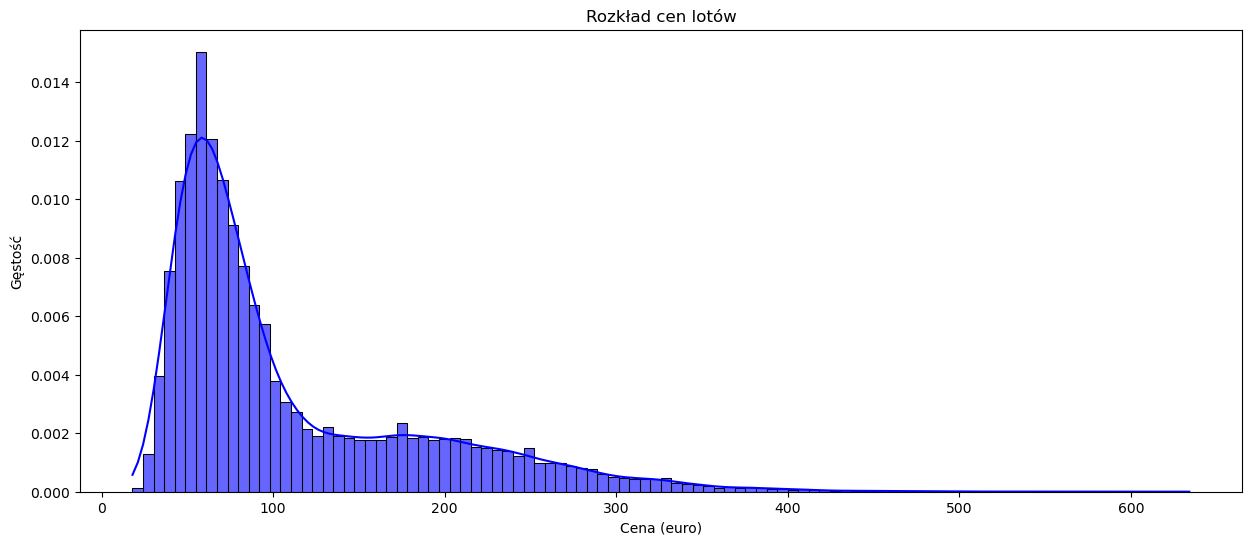

In [23]:
plt.figure(figsize=(15, 6))
sns.histplot(df['ticket_price_eur'], bins=100, kde=True, 
             color='blue', stat='density', alpha=0.6)

plt.title('Rozkład cen lotów')
plt.xlabel('Cena (euro)')
plt.ylabel('Gęstość')
plt.show()

In [24]:
df.groupby('sched_dep_year')[["ticket_price_eur"]].mean()

,ticket_price_eur
sched_dep_year,
2020,105.174866
2021,108.243513
2022,110.485348
2023,112.716864
2024,111.290112
2025,114.627229


**1.9. Generowanie zmiennej objaśnianej**:<br>

In [25]:
df['compensation_eligible'] = (df['delay_3h'] == True) & (df['delay_reason'] == 'Carrier Fault')
df['compensation_eligible'] = df['compensation_eligible'].astype(int)
print(df['compensation_eligible'].value_counts())

compensation_eligible
0    45649
1     4351
Name: count, dtype: int64


Eksport danych do pliku:

In [28]:
df.to_csv('raw_data.csv', index=False)

**1.10. Podział zbioru (train, test):**

In [29]:
split_date = '2023-01-01' # dzielę timestamp'em 1.1.2023: <ts: train_set, >ts: test_set
train_cv = df[df['sched_dep_time'] < split_date]
test = df[df['sched_dep_time'] >= split_date]

In [30]:
print(
    len(train_cv)+len(test)==len(df),
    train_cv['sched_dep_time'].max(),
    test['sched_dep_time'].min()
)

True 2022-12-31 20:40:00 2023-01-01 05:55:00


<a id="mod"></a>
## 2. Budowa i walidacja modelu
***

## I. Model TSA

**2.1. Przygotowanie zbioru pod model TSA**:<br>

**Dekompozycja szeregu czasowego (przyjmuję interwały miesięczne):**<br><br>
Zbiór treningowy:

In [31]:
train_cv_ts = train_cv.set_index('sched_dep_time')

train_cv_ts_me = train_cv_ts.resample('ME').agg({
    'compensation_eligible': ['sum', 'count']
})

train_cv_ts_me.columns = ['eligible', 'total']

train_cv_ts_me['rate'] = (
    train_cv_ts_me['eligible'] / train_cv_ts_me['total']
) * 100

print(train_cv_ts_me)

                eligible  total       rate
sched_dep_time                            
2020-01-31            91    730  12.465753
2020-02-29            81    696  11.637931
2020-03-31            44    734   5.994550
2020-04-30            43    757   5.680317
2020-05-31            51    722   7.063712
2020-06-30            47    699   6.723891
2020-07-31            73    697  10.473458
2020-08-31            80    703  11.379801
2020-09-30            45    693   6.493506
2020-10-31            35    706   4.957507
2020-11-30            40    718   5.571031
2020-12-31           116    723  16.044260
2021-01-31           115    765  15.032680
2021-02-28            85    636  13.364780
2021-03-31            43    786   5.470738
2021-04-30            37    725   5.103448
2021-05-31            39    714   5.462185
2021-06-30            48    757   6.340819
2021-07-31            67    715   9.370629
2021-08-31            76    730  10.410959
2021-09-30            44    678   6.489676
2021-10-31 

Zbiór testowy:

In [32]:
test_ts = test.set_index('sched_dep_time')

test_ts_me = test_ts.resample('ME').agg({
    'compensation_eligible': ['sum', 'count']
})

test_ts_me.columns = ['eligible', 'total']

test_ts_me['rate'] = (
    test_ts_me['eligible'] / test_ts_me['total']
) * 100

print(test_ts_me)

                eligible  total       rate
sched_dep_time                            
2023-01-31           110    755  14.569536
2023-02-28            75    650  11.538462
2023-03-31            58    743   7.806191
2023-04-30            54    732   7.377049
2023-05-31            35    719   4.867872
2023-06-30            56    699   8.011445
2023-07-31            70    763   9.174312
2023-08-31            73    697  10.473458
2023-09-30            35    655   5.343511
2023-10-31            45    697   6.456241
2023-11-30            27    674   4.005935
2023-12-31           123    749  16.421896
2024-01-31           107    737  14.518318
2024-02-29            86    639  13.458529
2024-03-31            36    699   5.150215
2024-04-30            34    675   5.037037
2024-05-31            39    766   5.091384
2024-06-30            59    693   8.513709
2024-07-31            74    742   9.973046
2024-08-31            82    698  11.747851
2024-09-30            45    720   6.250000
2024-10-31 

**2.2. EDA do szeregów czasowych**:<br>

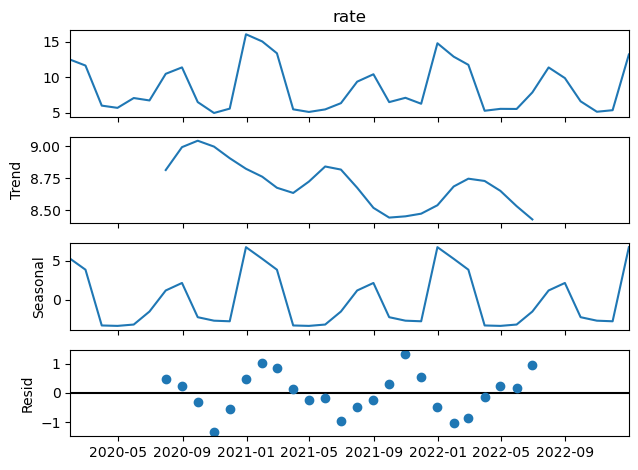

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(train_cv_ts_me['rate'], model='additive', period=12)

fig = decompose.plot()
plt.show()

**Wykresy autokorelacji:**

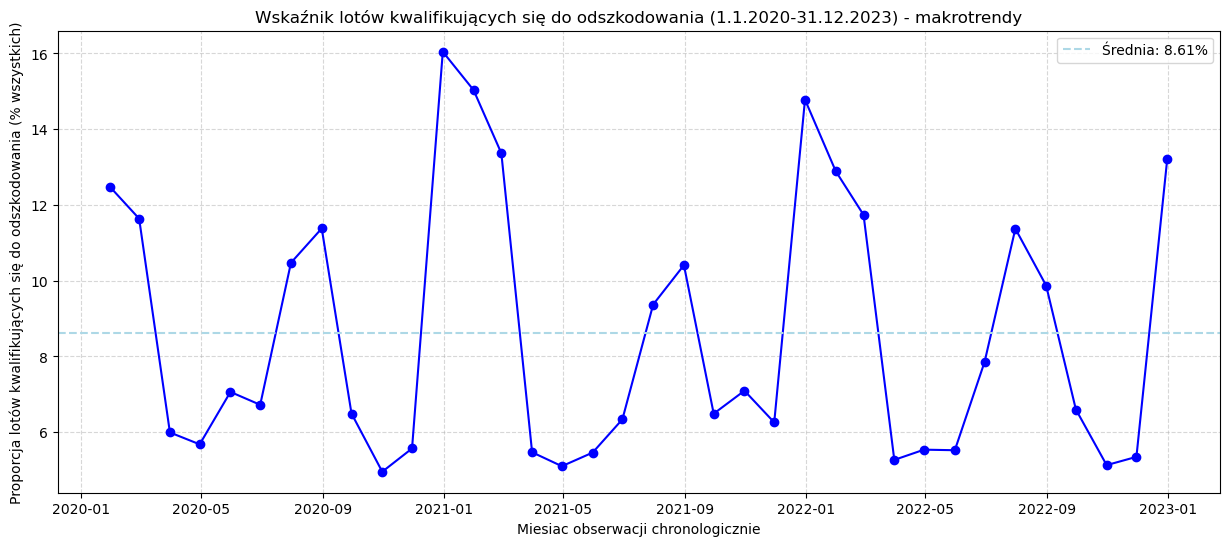

In [34]:
plt.figure(figsize=(15, 6))

plt.plot(
    train_cv_ts_me.index,
    train_cv_ts_me['rate'],
    marker='o',
    color='blue',
)

plt.title('Wskaźnik lotów kwalifikujących się do odszkodowania (1.1.2020-31.12.2023) - makrotrendy')
plt.xlabel('Miesiac obserwacji chronologicznie')
plt.ylabel('Proporcja lotów kwalifikujących się do odszkodowania (% wszystkich)')

mean_rate = train_cv_ts_me['rate'].mean()
plt.axhline(
    mean_rate,
    color='lightblue',
    linestyle='--',
    linewidth=1.5,
    label=f'Średnia: {mean_rate:.2f}%'
)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Sprawdzanie autokorelacji trendu:**

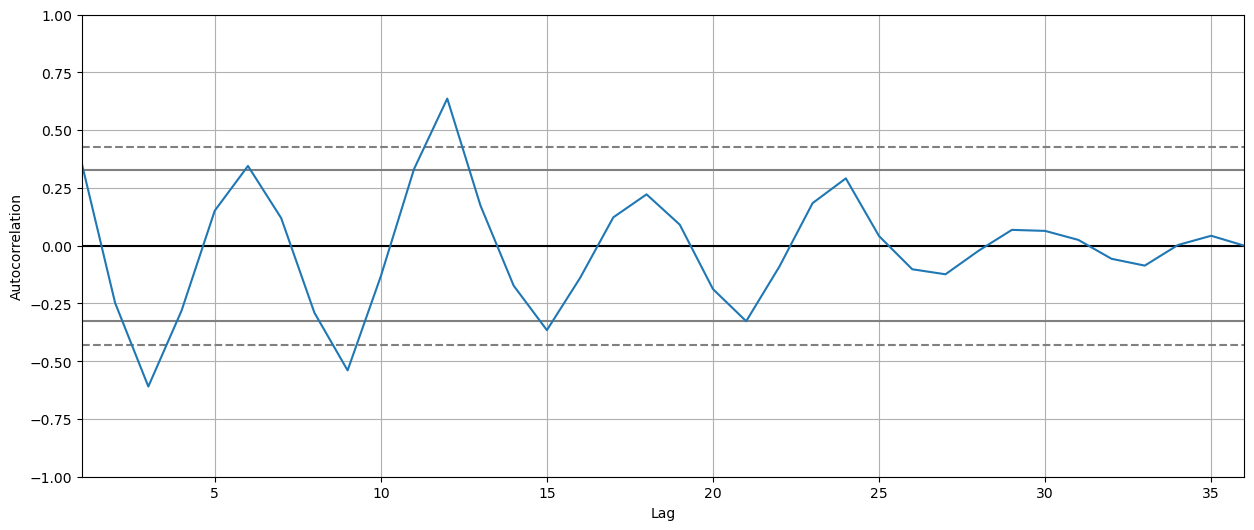

In [35]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(15, 6))
autocorrelation_plot(train_cv_ts_me['rate'])
plt.show()

**Obserwacja**: weryfikuję makrotrend, możliwa autokorelacja sezonowa S=12<br>

Sprawdzam jeszcze p-value ($H_0$ = szereg jest niestacjonarny (makrotrend)) testem ADF:<br>
* jeśli $H_0$ okaże się prawdziwa: przyjmuję  $d=1$ (jednokrotne różnicowanie makrotrendu)
* jeśli $H_0$ będzie fałszywa: przyjmuję $d=0$ (brak różnicowania)

In [36]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(train_cv_ts_me['rate'], autolag='AIC') 

adfoutput = pd.Series(adf[0:4], index=['ADF','p-value','Lags','Liczba obserwacji'])
       
print(adfoutput)
    
if adf[1] <= 0.05:
    print("\nDecyzja: Odrzucam H0. \nWniosek: Szereg czasowy jest stacjonarny (makrotrend) (d=0).")
else:
    print("\nDecyzja: Nie odrzucam H0. \nWniosek: Szereg czasowy jest niestacjonarny (d=1).")

ADF                 -8.407423e+00
p-value              2.148787e-13
Lags                 8.000000e+00
Liczba obserwacji    2.700000e+01
dtype: float64

Decyzja: Odrzucam H0. 
Wniosek: Szereg czasowy jest stacjonarny (makrotrend) (d=0).


**Autokorelacja sezonowa:**

**Obserwacja**: możliwa obecność autokorelacji sezonowej. Sprawdzam przedziały ufności dla hipotezy D=0 (brak różnicowania sezonowego) i dla D=1 (jednokrotne różnicowanie sezonowe) przy S=12:

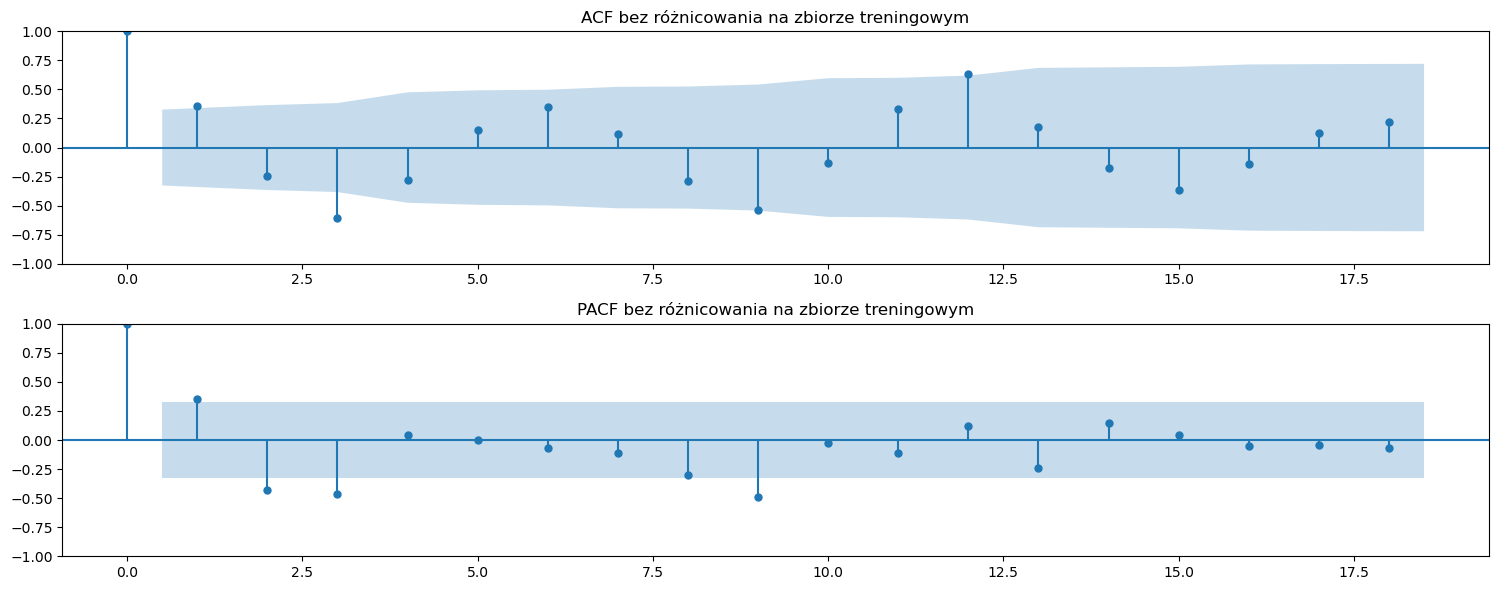

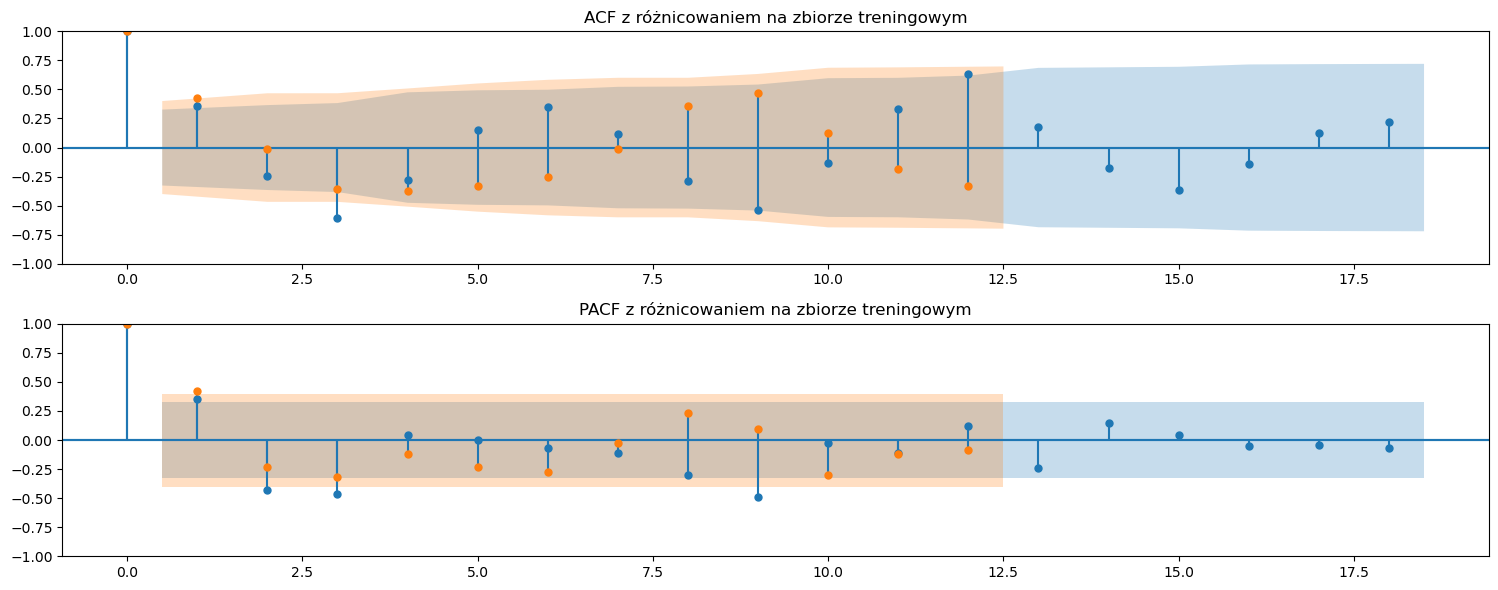

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

seasonal_ac = train_cv_ts_me['rate'] # brak różnicowania 
seasonal_ac1 = train_cv_ts_me['rate'].diff(12).dropna() # różnicowanie

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

plot_acf(
    seasonal_ac,
    lags=18, 
    ax=axes[0],               
    title='ACF bez różnicowania na zbiorze treningowym'
)

plot_pacf(
    seasonal_ac,
    lags=18, 
    ax=axes[1],               
    title='PACF bez różnicowania na zbiorze treningowym'
)

plt.tight_layout()
plt.show()

plot_acf(
    seasonal_ac1,
    lags=12, 
    ax=axes[0],               
    title='ACF z różnicowaniem na zbiorze treningowym'
)

plot_pacf(
    seasonal_ac1,
    lags=12, 
    ax=axes[1],               
    title='PACF z różnicowaniem na zbiorze treningowym'
)

**Wniosek:** rozważam jednokrotne różnicowanie sezonowe (D=1), S=12.

Rozważam modele **ARIMA i SARIMA**.

**2.3. Walidacja modelu TS ARIMA i TS SARIMA (z modelowaniem sezonowym) - Walk-Forward CV**:<br><br>
Modele testowane w CV (+ założenia, jakie reprezentuja):
* ARIMA(0,0,0) - najprostszy model średniej kroczacej
  
* SARIMA(0,0,0)(1,0,0,12) - autoregresja sezonowa (P=1 przy S=12)
* SARIMA(0,0,0)(0,1,0,12) - różnicowanie sezonowe (D=1 przy S=12)
* SARIMA(0,0,0)(1,1,0,12) - autoregresja sezonowa (P=1 przy S=12), różnicowanie sezonowe (D=1 przy S=12)

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

hiperparams = [
    # ARIMA:
    {'makro_order': (0, 0, 0), 'sezon': (0, 0, 0, 0), 'n': 'ARIMA(0,0,0)'},

    # SARIMA:
    {'makro_order': (0, 0, 0), 'sezon': (1, 0, 0, 12), 'n': 'SARIMA(0,0,0)(1,0,0)'},
    {'makro_order': (0, 0, 0), 'sezon': (0, 1, 0, 12), 'n': 'SARIMA(0,0,0)(0,1,0)'},
    {'makro_order': (0, 0, 0), 'sezon': (1, 1, 0, 12), 'n': 'SARIMA(0,0,0)(1,1,0)'}
]

results = {}
ts_train = train_cv_ts_me['rate'] 

train_window = 30 # train: pierwsze 30 miesięcy
test_window = len(ts_train) - train_window # test: 6 ostatnich miesięcy

for model_set in hiperparams:
    train_rows = [x for x in ts_train.iloc[:train_window]]
    predictions = []
    
    for test_rows in range(test_window):
        try:
            model = SARIMAX(
                train_rows,
                order=model_set['makro_order'],
                seasonal_order=model_set['sezon'],
                measurement_error = True
            )
            model_fit = model.fit(disp=False)
            
            pred = model_fit.forecast(steps=1)[0]
            predictions.append(pred)
            
            obs = ts_train.iloc[train_window + test_rows]
            train_rows.append(obs)
            
        except Exception as e:
            predictions.append(np.nan) 
            train_rows.append(ts_train.iloc[train_window + test_rows])
            
    test_real_value = ts_train.iloc[train_window:]
    error = np.sqrt(mean_squared_error(test_real_value, predictions))
    
    results[model_set['n']] = {
        'err': error, 
        'makro_order': model_set['makro_order'], 
        'sezon': model_set['sezon']
    }

sorted_results = sorted(results.items(), key=lambda result: result[1]['err'])

best_model_name = sorted_results[0][0]
best_model_data = sorted_results[0][1]

best_makro_order = best_model_data['makro_order']
best_sezon_order = best_model_data['sezon']

for name, data in sorted_results:
    print(f"{name}: RMSE = {data['err']:.4f}")

print(f'Najniższy bład: {best_model_name}. Wartość: {best_model_data['err']}')

SARIMA(0,0,0)(1,0,0): RMSE = 1.2147
SARIMA(0,0,0)(0,1,0): RMSE = 1.2364
SARIMA(0,0,0)(1,1,0): RMSE = 1.2915
ARIMA(0,0,0): RMSE = 9.1247
Najniższy bład: SARIMA(0,0,0)(1,0,0). Wartość: 1.2146997334825622


In [39]:
train_cv_ts_me['rate'].std()

3.4225073107490136

In [40]:
best_makro_order,best_sezon_order

((0, 0, 0), (1, 0, 0, 12))

**2.4. Wybór najlepszego modelu, predykcja na zbiorze treningowym**:<br>

In [41]:
winning_model = SARIMAX(
    ts_train, 
    order=best_makro_order, 
    seasonal_order=best_sezon_order, 
    measurement_error=True 
)
model_fit = winning_model.fit(disp=False) 

fitted_values = model_fit.get_prediction(start=0, end=len(ts_train)-1, dynamic=False)
fitted_mean = fitted_values.predicted_mean
residuals = model_fit.resid

In [42]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                     rate   No. Observations:                   36
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                 -81.939
Date:                  Sat, 21 Feb 2026   AIC                            169.878
Time:                          22:37:01   BIC                            174.628
Sample:                      01-31-2020   HQIC                           171.536
                           - 12-31-2022                                         
Covariance Type:                    opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.S.L12                  0.9995      0.003    375.848      0.000       0.994       1.005
var.measurement_error     0.7695      0.494      1.557      0.120      -0.199       1.738
sigma2                    0.0785      0.459      0.171      0.864      -0.821       0.978
===================================================================================
Ljung-Box (L1) (Q):                   9.98   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               0.79   Skew:                            -0.03
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
residuals[12:].describe()

count    24.000000
mean     -0.093186
std       1.220298
min      -2.101020
25%      -0.871535
50%      -0.492892
75%       0.328006
max       2.689608
dtype: float64

Wykres rozkładu reszt:

<Axes: ylabel='Density'>

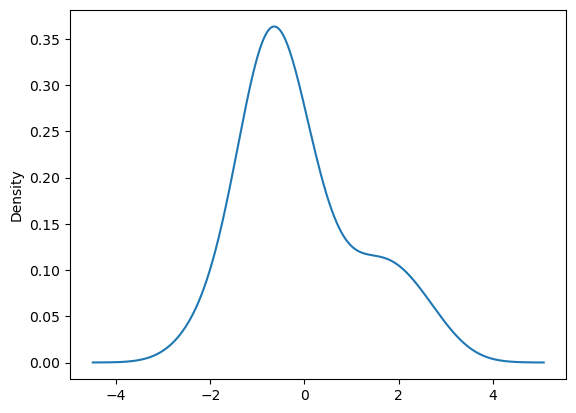

In [44]:
residuals[12:].plot(kind='kde')

Wykres dopasowania i reszt:

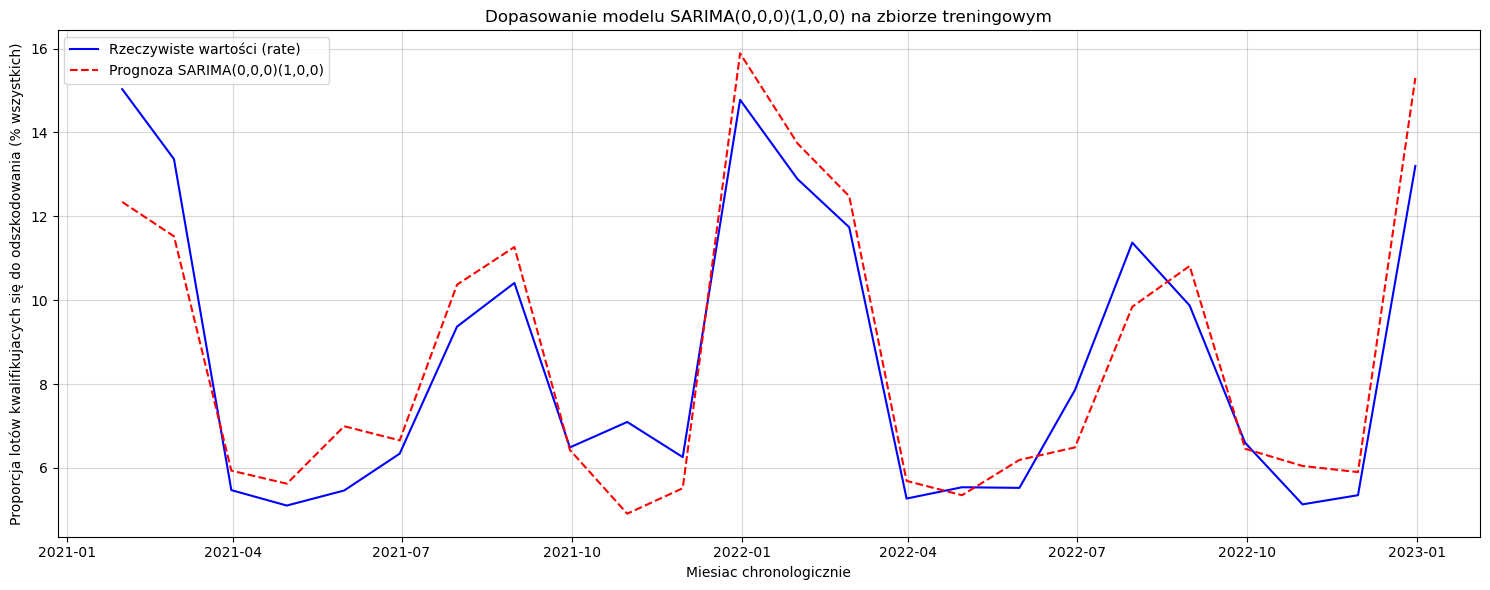

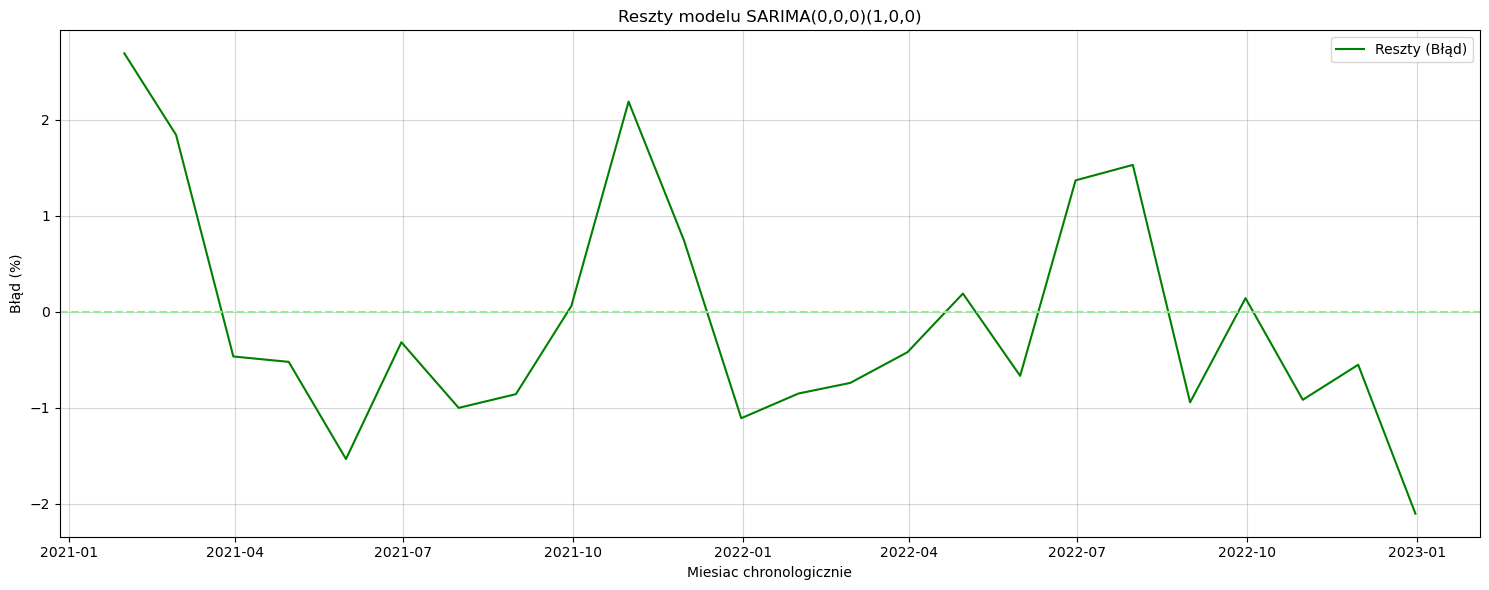

In [45]:
### wykres dopasowania ###

plt.figure(figsize=(15, 6))

# dane rzeczywiste
plt.plot(ts_train[12:].index, ts_train[12:].values, label='Rzeczywiste wartości (rate)', color='blue')

# prognoza
plt.plot(ts_train[12:].index, fitted_mean[12:].values, label='Prognoza '+best_model_name, color='red', linestyle='--')

plt.title(f'Dopasowanie modelu {best_model_name} na zbiorze treningowym')
plt.xlabel('Miesiac chronologicznie')
plt.ylabel('Proporcja lotów kwalifikujacych się do odszkodowania (% wszystkich)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# wykres reszt
plt.figure(figsize=(15, 6))
plt.plot(residuals[12:].index, residuals[12:].values, label='Reszty (Błąd)', color='green')
plt.axhline(0, color='lightgreen', linestyle='--')
plt.title(f'Reszty modelu {best_model_name}')
plt.xlabel('Miesiac chronologicznie')
plt.ylabel('Błąd (%)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

**2.5. Predykcja najlepszego modelu TSA na zbiorze testowym**:<br>

In [46]:
test_pred = model_fit.get_prediction(
    start=len(ts_train), 
    end=len(ts_train) + len(test_ts_me) - 1, 
    dynamic=True
)

test_pred_mean = test_pred.predicted_mean

In [47]:
print(f'Bład (test set): {np.sqrt(mean_squared_error(test_ts_me['rate'], test_pred_mean))}\n SD: {test_ts_me['rate'].std()}')

Bład (test set): 1.1859522739714512
 SD: 3.682172450480989


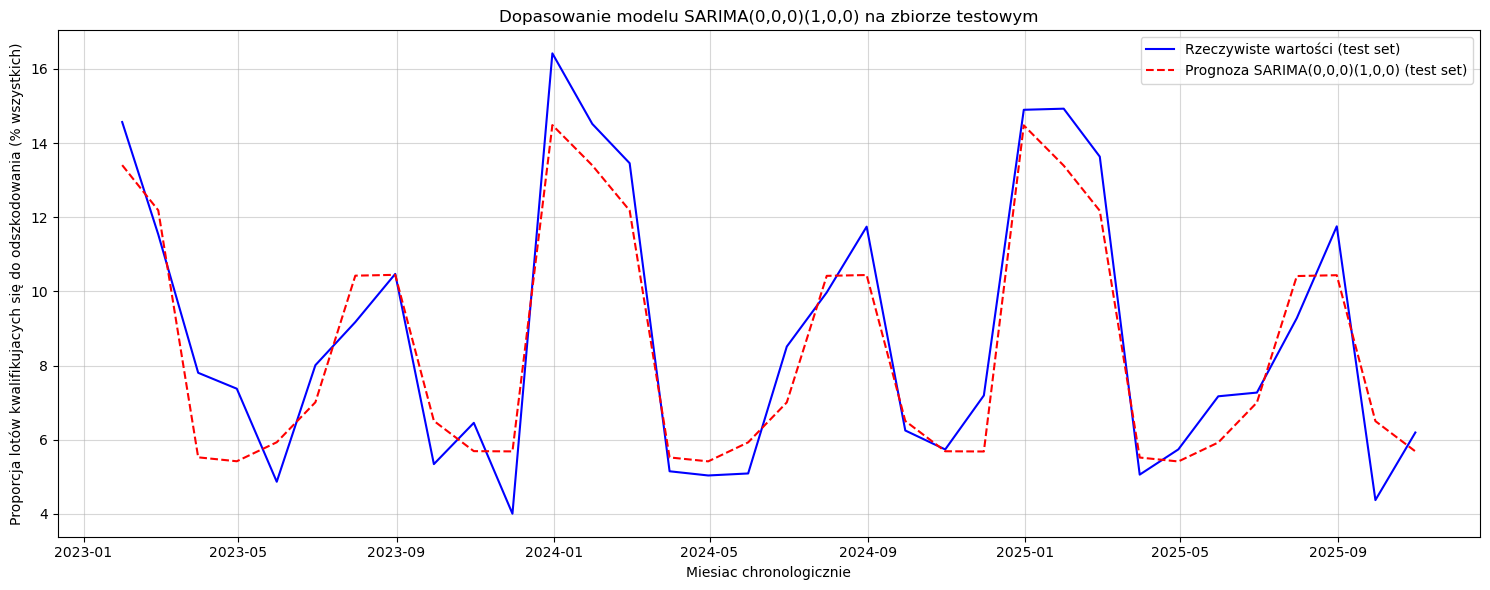

In [48]:
plt.figure(figsize=(15, 6))

plt.plot(test_ts_me.index, test_ts_me['rate'].values, label='Rzeczywiste wartości (test set)', color='blue')

plt.plot(test_ts_me.index, test_pred_mean.values, label='Prognoza '+best_model_name+' (test set)', color='red', linestyle='--')

plt.title(f'Dopasowanie modelu {best_model_name} na zbiorze testowym')
plt.xlabel('Miesiac chronologicznie')
plt.ylabel('Proporcja lotów kwalifikujacych się do odszkodowania (% wszystkich)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

**Wniosek**: Model wyjaśnia duza część wariancji. Do pozostałej części (np. sezonowość tyogdniowa, godzinowa itp.) i w celu indywidualnej predykcji zaimplementuję jeszcze model drzewiasty (RandomForest) ze zmienna objaśniajaca macro_risk (prognoza modelu TSA).

**Prognoza pełnego trendu** (metoda `predict` dla wartości ze zbioru testowego (poza zakresem zbioru treningowego) automatycznie prognozuje out-of-sample):

In [49]:
full_trend = model_fit.predict(start=0, end=len(train_cv_ts_me) + len(test_ts_me) - 1)

In [50]:
df_macro_risk = pd.DataFrame(full_trend[12:]) # biorę tylko nieodstajace predykcje (te po 'rozgrzaniu' modelu po jednym pełnym cyklu)
df_macro_risk.columns = ['macro_risk']
df_macro_risk.index.name = 'month_key'
df_macro_risk.index = pd.to_datetime(df_macro_risk.index.astype(str)) # uzgadniam typy żeby połaczyć po indeksie z df (merge)

In [51]:
df['month_key'] = df['sched_dep_time'].dt.date + pd.offsets.MonthEnd(0) # koniec miesiaca
df['month_key'] = pd.to_datetime(df['month_key']) # uzgadniam typy

In [52]:
df_join = df.merge(df_macro_risk[['macro_risk']], left_on='month_key', right_index=True, how='inner') # inner join - usuwam wiersze z odstajacymi prognozami makrotrendu 'macro_risk'

In [53]:
df_join

,origin,dest,dist_km,airline,plane,sched_duration,flight_code,sched_dep_time,sched_dep_year,sched_dep_month,...,act_dep_time,act_duration,act_arr_time,delay_minutes,delay_3h,delay_reason,ticket_price_eur,compensation_eligible,month_key,macro_risk
8578,DOH,CDG,4900,Qatar Airways,Airbus A380,372,QA334,2021-01-01 05:45:00,2021,1,...,2021-01-01 08:38:00,358,2021-01-01 14:36:00,159,False,Carrier Fault,168.0,0,2021-01-31,12.343072
8579,FCO,DUB,1900,Aer Lingus,Airbus A320,177,AE372,2021-01-01 06:05:00,2021,1,...,2021-01-01 06:05:00,190,2021-01-01 09:15:00,13,False,NaN,63.0,0,2021-01-31,12.343072
8580,WRO,VIE,360,LOT,Embraer 170,74,LO603,2021-01-01 06:30:00,2021,1,...,2021-01-01 06:33:00,77,2021-01-01 07:50:00,6,False,NaN,48.0,0,2021-01-31,12.343072
8581,FCO,OPO,1800,Ryanair,Boeing 737-800,189,RY940,2021-01-01 07:05:00,2021,1,...,2021-01-01 08:04:00,197,2021-01-01 11:21:00,67,False,Carrier Fault,76.0,0,2021-01-31,12.343072
8582,LIS,VCE,1700,TAP Portugal,Airbus A320,181,TA162,2021-01-01 07:35:00,2021,1,...,2021-01-01 07:37:00,192,2021-01-01 10:49:00,13,False,NaN,57.0,0,2021-01-31,12.343072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,FRA,VIE,480,Lufthansa,Airbus A320,79,LU215,2025-10-31 18:30:00,2025,10,...,2025-10-31 20:28:00,85,2025-10-31 21:53:00,124,False,Extraordinary,60.0,0,2025-10-31,5.687501
49996,FCO,OPO,1800,Ryanair,Boeing 737-800,189,RY606,2025-10-31 19:05:00,2025,10,...,2025-10-31 19:05:00,180,2025-10-31 22:05:00,-9,False,NaN,75.0,0,2025-10-31,5.687501
49997,DUS,PMI,1500,Eurowings,Airbus A320,165,EU290,2025-10-31 20:40:00,2025,10,...,2025-10-31 21:49:00,160,2025-11-01 00:29:00,64,False,Extraordinary,73.0,0,2025-10-31,5.687501
49998,MAD,BUD,2070,Iberia,Airbus A320,181,IB964,2025-10-31 20:55:00,2025,10,...,2025-10-31 22:35:00,178,2025-11-01 01:33:00,97,False,Carrier Fault,100.0,0,2025-10-31,5.687501


In [55]:
df_join = df_join.drop('month_key', axis=1)

In [56]:
df_join.to_csv('macro_risk_data.csv', index=False)

## II. Model RandomForest
Pozostała część wariancji (mikrotrendy, sezonowość) wyjaśniam modelem RF.<br>

**2.6. Przygotowywanie zmiennych**:<br>

Zmienne objaśniajace:

In [57]:
x_num = ['sched_dep_time', 'dist_km', 'sched_duration', 'weather_intensity', 'ticket_price_eur', 'sched_dep_year', 'sched_dep_hour', 'sched_dep_month', 'sched_dep_day_of_week', 'macro_risk'] #numeryczne
x_cat = ['origin', 'dest', 'airline', 'plane', 'weather_origin'] # kategoryczne

In [58]:
df_x_num = df_join[x_num]

One-hot-encoding dla zmiennych kategorycznych:

In [59]:
df_x_cat = pd.get_dummies(df_join[x_cat], columns=x_cat, drop_first=True)

In [60]:
df_x = pd.concat([df_x_num, df_x_cat], axis=1) # łacze zmienne kategoryczne i numeryczne

Zmienna objaśniana:

In [61]:
start_date = '01-01-2021' # dopasowuje do zakresu df_x

In [62]:
df_y = df_join[['sched_dep_time', 'compensation_eligible']]
df_y = df_y[df_y['sched_dep_time'] >= start_date]
print(len(df_x) == len(df_y))

True


Podział train/test:

In [63]:
split_date = '2024-01-01'

train_x = df_x[df_x['sched_dep_time'] < split_date]
test_x = df_x[df_x['sched_dep_time'] >= split_date]

train_y = df_y['compensation_eligible'][df_y['sched_dep_time'] < split_date]
test_y = df_y['compensation_eligible'][df_y['sched_dep_time'] >= split_date]

print(
    len(train_x)+len(test_x)==len(df_x),
    train_x['sched_dep_time'].max(),
    test_x['sched_dep_time'].min()
)

True 2023-12-31 23:00:00 2024-01-01 00:10:00


In [64]:
train_x = train_x.iloc[:, 1:] # usuwam kolumnę DateTime ze zmiennych objaśniajacych 
test_x = test_x.iloc[:, 1:]

**2.7. Budowa modelu RandomForest i predykcja na zbiorze testowym:**:<br>

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

model = RandomForestClassifier(
    n_estimators=500,       
    max_depth=10,            
    min_samples_leaf=30, 
    class_weight='balanced', 
    n_jobs=-1,              
    random_state=123
)

model.fit(train_x, train_y)

prediction = model.predict_proba(test_x)[:, 1]

print('done')

done


In [67]:
auc_score = roc_auc_score(test_y, prediction)
print(auc_score)

0.7212249738212322


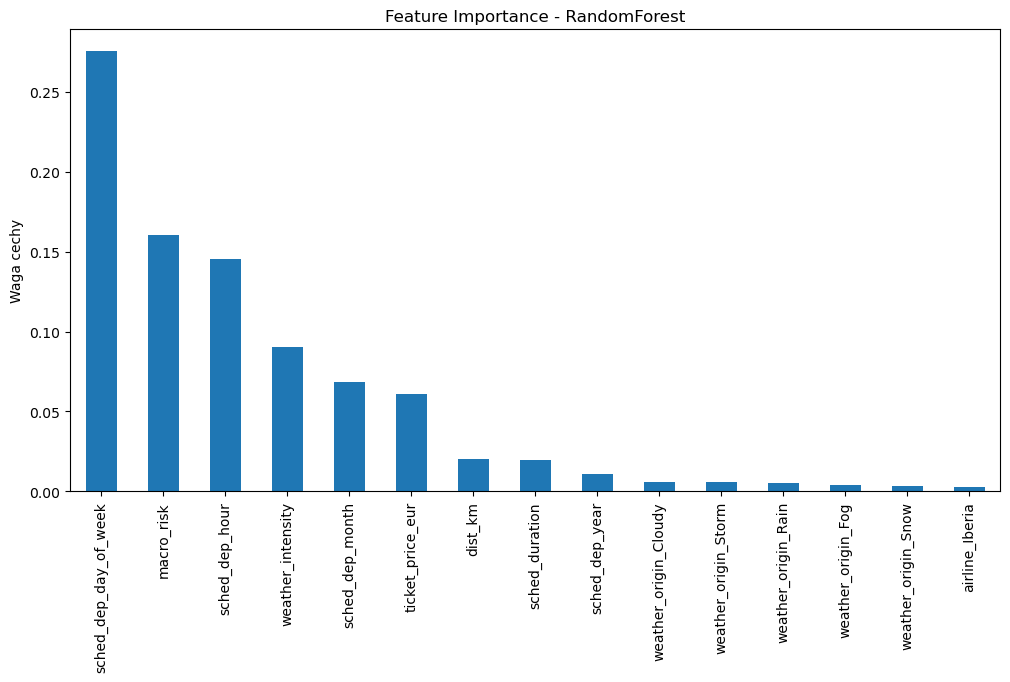

weather_origin_Fog      0.004111
weather_origin_Snow     0.003353
airline_Iberia          0.002763
origin_MAD              0.002741
plane_Boeing 737-800    0.002625
                          ...   
origin_IST              0.000090
dest_TLV                0.000078
origin_DUS              0.000067
dest_TSF                0.000064
origin_POZ              0.000059
Length: 118, dtype: float64


In [68]:
importances = model.feature_importances_
names = train_x.columns

importances = pd.Series(importances, index=names).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importances.head(15).plot(kind='bar')
plt.title("Feature Importance - RandomForest")
plt.ylabel("Waga cechy")
plt.show()

low_importance = importances[importances < 0.005]
print(low_importance)

In [69]:
prediction_train = model.predict_proba(train_x)[:, 1]

auc_score = roc_auc_score(train_y, prediction_train) #sprawdzam AUC na train set
print(auc_score) 

0.7693465827624422


**Obserwacja**: model ma wiele nieistotnych zmiennych, dodatkowo model jest przeuczony szumu ze zbioru treningowego (wysoki AUC na train set).

**Rozwiazanie:**
* zostawiam tylko najistotniejsze zmienne x i patrzę jak wpływaja na AUC.
* manipuluję maksymalna głębokościa drzewa i liczebnościa liścia

In [70]:
relevant_x = importances[importances > 0.005].index.tolist()

train_x = train_x[relevant_x]
test_x = test_x[relevant_x]

In [71]:
model = RandomForestClassifier( # taki sam model z usuniętymi zmiennymi nieistotnymi 
    n_estimators=500,       
    max_depth=10,            
    min_samples_leaf=30, 
    class_weight='balanced', 
    n_jobs=-1,              
    random_state=123
)

model.fit(train_x, train_y)

prediction = model.predict_proba(test_x)[:, 1]

print('done')

done


In [72]:
auc_score = roc_auc_score(test_y, prediction)
print(auc_score)

0.7218573433797921


In [73]:
model = RandomForestClassifier( # taki sam model z usuniętymi zmiennymi nieistotnymi 
    n_estimators=500,       
    max_depth=7,            
    min_samples_leaf=35, 
    class_weight='balanced', 
    n_jobs=-1,              
    random_state=123
)

model.fit(train_x, train_y)

prediction = model.predict_proba(test_x)[:, 1]

print('done')

done


In [74]:
auc_score = roc_auc_score(test_y, prediction)
print(auc_score)

0.7245496747256238


Wniosek: AUC najwyższy na modelu z usuniętymi zmiennymi nieistotnymi, głębokościa do 7 gałęzi i min. liczebnoscia liścia = 35

Tworzenie i eksport gotowego pliku z danymi - test set (real class + wartości score modelu):

In [106]:
scores = df_join.loc[test_x.index]
scores['score'] = prediction

In [118]:
scores.to_csv('test_scores_data.csv', index=False)

<a id="sym"></a>
## 4. Tworzenie symulacji biznesowej
***

**Kontekst prawny**: zgodnie z *Rozporządzeniem (WE) 261/2004 Parlamentu Europejskiego i Rady z 11.02.2004* za opóźniony lot przysługuje odszkodowanie jeżeli:
* opóźnienie wynosi co najmniej 3 godziny od planowanej godziny przylotu,
* opóźnienie nie zostało spowodowane przez nadzwyczajne okoliczności,
* min. jedno lotnisko (wylotu lub przylotu) znajduje się na terytorium UE.

**Kwoty odszkodowania**:
* €250 dla lotów do 1500 km,
* €400 dla lotów o długości pomiędzy 1500 a 3500 km
* €600 dla lotów o długości pow. 3500 km

In [119]:
def get_compensation_value(dist): # funkcja pomocnicza
    if dist < 1500:
        return 250.0
    elif dist <= 3500:
        return 400.0
    else:
        return 600.0

In [120]:
df_sim = df.loc[test_y.index, ['ticket_price_eur', 'dist_km']].copy() # tworzę df do symulacji (tylko wiersze z test set)
df_sim['real_class'] = test_y
df_sim['score'] = prediction

df_sim['potential_compensation'] = df_sim['dist_km'].apply(get_compensation_value) # wysokość potencjalnego odszkodowania

**Symulacja:**

In [121]:
thresholds = np.arange(0.05, 1.0, 0.01) # progi odcięcia
results = []

for t in thresholds:

    buy = df_sim['score'] > t # kup jeśli predykcja większa niż aktulny próg odcięcia
    
    cost = df_sim.loc[buy, 'ticket_price_eur'].sum() # zapłać za kupione bilety, zlicz całość kosztów
    
    compensation_received = buy & (df_sim['real_class'] == 1) # czy przyznano odszkodowanie
    
    revenue = df_sim.loc[compensation_received, 'potential_compensation'].sum() # suma zysku z przyznanych odszkodowań
    
    profit = revenue - cost # balans końcowy w EUR
    
    roi = (profit / cost) * 100 if cost > 0 else 0 
    
    volume = buy.sum() # liczba zakupionych biletów w scenariuszu
    
    results.append({
        'cutoff': t,
        'profit': profit,
        'roi': roi,
        'volume': volume,
        'revenue': revenue,
        'cost': cost
    })

df_results = pd.DataFrame(results)

print('done')

done


In [122]:
df_results[df_results['profit']>0]

,cutoff,profit,roi,volume,revenue,cost
65,0.70,301.0,0.519422,531,58250.0,57949.0
66,0.71,1961.0,4.310932,423,47450.0,45489.0
67,0.72,2695.0,7.676969,342,37800.0,35105.0
68,0.73,1530.0,5.902778,266,27450.0,25920.0


**Wykres zysku i ROI:**

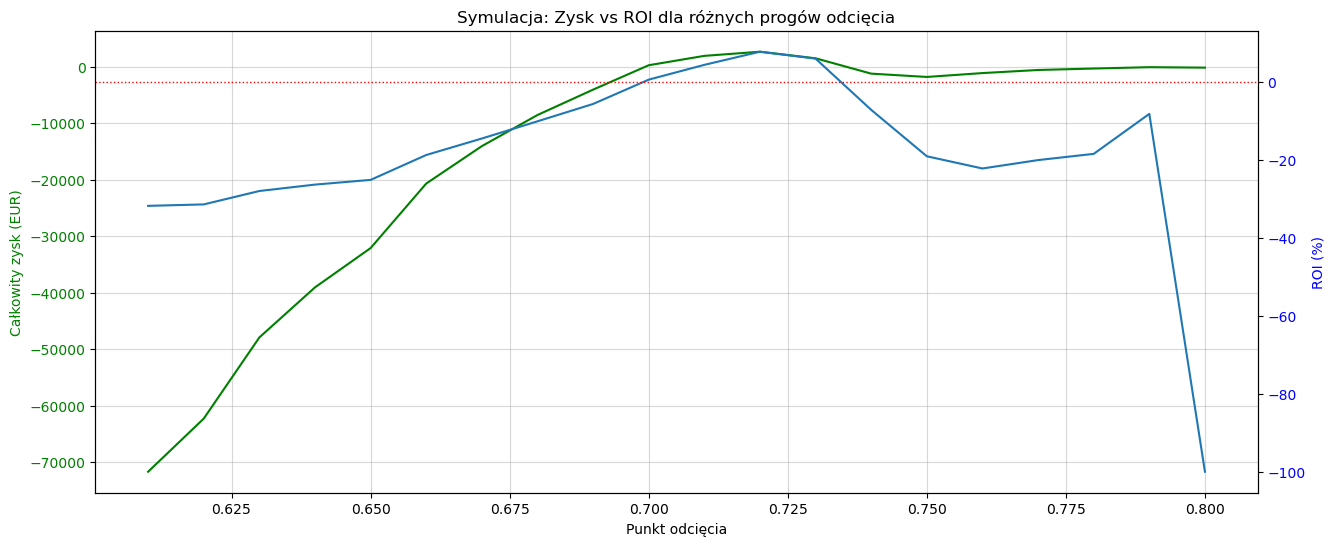

In [123]:
plt.figure(figsize=(15, 6))

max_pred = df_sim['score'].max() # wykresy rysuję tylko do maksymalnego score
mask = (df_results['cutoff'] > max_pred-0.2) & (df_results['cutoff'] <= max_pred) # i tylko dla najwyższych punktów odcięcia (skala krzywej)

# zysk
ax1 = plt.gca()
line1 = ax1.plot(df_results['cutoff'][mask], df_results['profit'][mask], 'g-', label='Zysk (EUR)')
ax1.set_xlabel('Punkt odcięcia')
ax1.set_ylabel('Całkowity zysk (EUR)', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True, alpha=0.5)

# roi
ax2 = ax1.twinx()
line2 = ax2.plot(df_results['cutoff'][mask], df_results['roi'][mask])
ax2.set_ylabel('ROI (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# linia zera
plt.axhline(0, color='red', linewidth=1, linestyle=':', label='Próg rentowności')

plt.title('Symulacja: Zysk vs ROI dla różnych progów odcięcia')
plt.show()

In [124]:
best_profit_scenario = df_results[df_results['profit'].max()==df_results['profit']]
best_profit_cutoff = best_profit_scenario['cutoff'].values[0] # konwersja Pandas Series na float

best_roi_scenario = df_results[df_results['roi'].max()==df_results['roi']]
best_roi_cutoff = best_roi_scenario['cutoff'].values[0]

In [125]:
print(f'Scenariusz z najwyższym zyskiem:\n{best_profit_scenario}\n\nScenariusz z najwyższym ROI:\n {best_roi_scenario}')

Scenariusz z najwyższym zyskiem:
    cutoff  profit       roi  volume  revenue     cost
67    0.72  2695.0  7.676969     342  37800.0  35105.0

Scenariusz z najwyższym ROI:
     cutoff  profit       roi  volume  revenue     cost
67    0.72  2695.0  7.676969     342  37800.0  35105.0


**Analiza VaR:**<br>
Dla scenariusza z najwyższym ROI:

In [126]:
df_to_buy = df_sim[df_sim['score'] > best_roi_cutoff].copy() 

n_iterations = 10000 # monte carlo
profits_roi = []

for i in range(n_iterations):
    
    sample = df_to_buy.sample(frac=1.0, replace=True) # losowanie ze zwracaniem
    
    cost = sample['ticket_price_eur'].sum()

    revenue = sample.loc[sample['real_class'] == 1, 'potential_compensation'].sum()
    
    profit = revenue - cost
    profits_roi.append(profit)

print('done')

done


In [127]:
from scipy import stats

profits_roi = np.array(profits_roi)

var = np.percentile(profits_roi, 5) # VaR 95%§

loss_prob = stats.percentileofscore(profits_roi, 0)

print(f'VaR: {var:.2f} EUR \nPrawdopodobieństwo zysku: {100-loss_prob:.2f} %')

VaR: -2839.45 EUR 
Prawdopodobieństwo zysku: 78.14 %


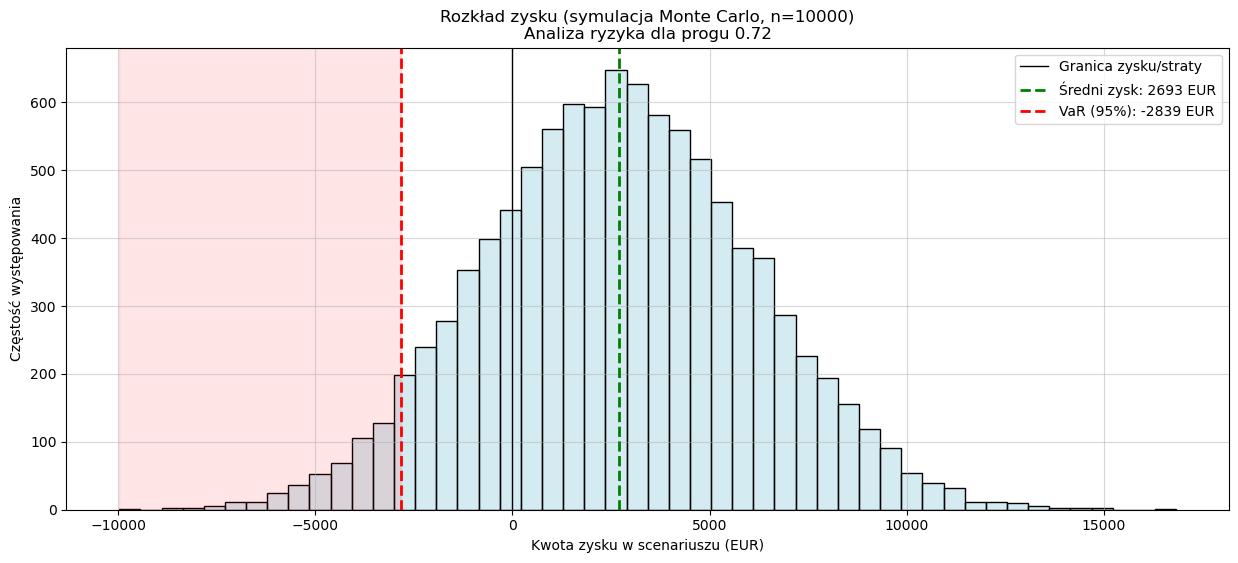

In [128]:
plt.figure(figsize=(15, 6))

sns.histplot(profits_roi, color='lightblue', bins=50, alpha=0.5)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1, label='Granica zysku/straty')
plt.axvline(x=profits_roi.mean(), color='green', linestyle='--', linewidth=2, label=f'Średni zysk: {profits_roi.mean():.0f} EUR')
plt.axvline(x=var, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): {var:.0f} EUR')

plt.axvspan(profits_roi.min(), var, color='red', alpha=0.1)

plt.title(f'Rozkład zysku (symulacja Monte Carlo, n={n_iterations})\nAnaliza ryzyka dla progu {best_roi_cutoff:.2f}')
plt.xlabel('Kwota zysku w scenariuszu (EUR)')
plt.ylabel('Częstość występowania')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

Dla scenariusza z najwyższym zyskiem (B):

In [129]:
df_to_buy = df_sim[df_sim['score'] > best_profit_cutoff].copy() 

n_iterations = 10000 # monte carlo
profits_profit = []

for i in range(n_iterations):
    
    sample = df_to_buy.sample(frac=1.0, replace=True) # losowanie ze zwracaniem
    
    cost = sample['ticket_price_eur'].sum()

    revenue = sample.loc[sample['real_class'] == 1, 'potential_compensation'].sum()
    
    profit = revenue - cost
    profits_profit.append(profit)

print('done')

done


In [130]:
profits_profit = np.array(profits_profit)

var = np.percentile(profits_profit, 5) # VaR 95%

loss_prob = stats.percentileofscore(profits_profit, 0)

print(f'VaR: {var:.2f} EUR \nPrawdopodobieństwo zysku: {100-loss_prob:.2f} %')

VaR: -2794.05 EUR 
Prawdopodobieństwo zysku: 78.28 %


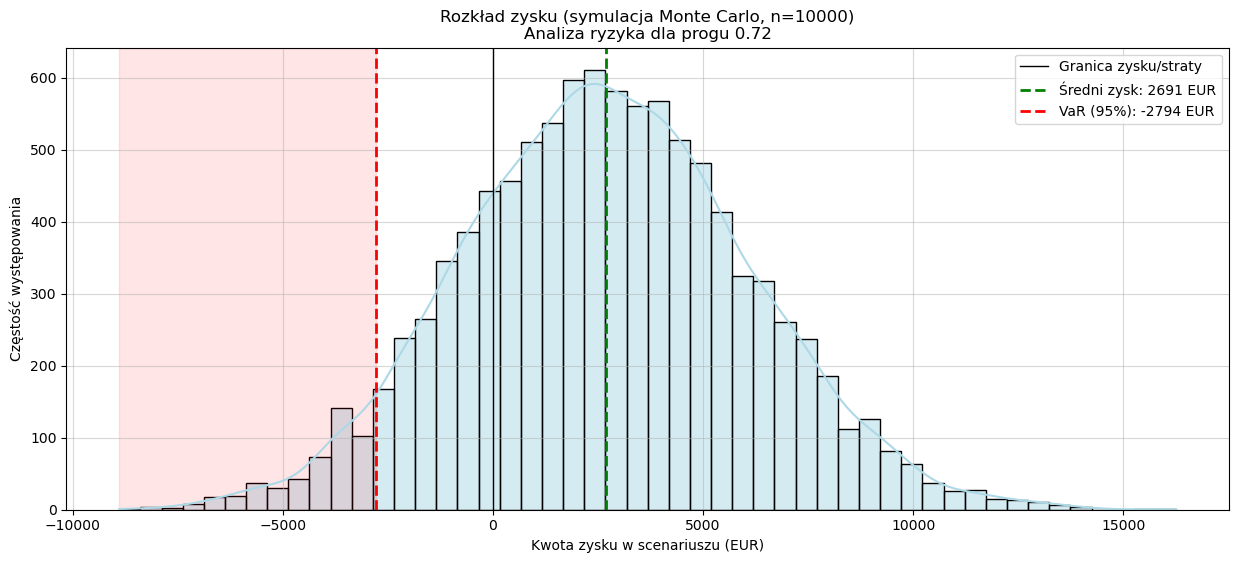

In [131]:
plt.figure(figsize=(15, 6))

sns.histplot(profits_profit, kde=True, color='lightblue', bins=50, alpha=0.5)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1, label='Granica zysku/straty')
plt.axvline(x=profits_profit.mean(), color='green', linestyle='--', linewidth=2, label=f'Średni zysk: {profits_profit.mean():.0f} EUR')
plt.axvline(x=var, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): {var:.0f} EUR')

plt.axvspan(profits_profit.min(), var, color='red', alpha=0.1)

plt.title(f'Rozkład zysku (symulacja Monte Carlo, n={n_iterations})\nAnaliza ryzyka dla progu {best_profit_cutoff:.2f}')
plt.xlabel('Kwota zysku w scenariuszu (EUR)')
plt.ylabel('Częstość występowania')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

Porównanie (dla tego ziarna losowego best roi cutoff == best profit cutoff, więc to po prostu 2 różne symulacje Monte Carlo dla tego samego progu):

In [132]:
scenariusze = profits_profit,profits_roi
pd_data = []

for zyski in scenariusze:
    pd_data.append(stats.describe(zyski))

df3 = pd.DataFrame(pd_data)
df3.insert(0, "scenario", ['best profit','best roi'])
df3 = df3.rename(columns={"variance":"std"})
df3['std'].apply(lambda x: x**0.5)
df3

,scenario,nobs,minmax,mean,std,skewness,kurtosis
0,best profit,10000,"(-8892.0, 16256.0)",2691.2304,1.151184e+07,0.078630,0.002133
1,best roi,10000,"(-9974.0, 16831.0)",2693.0388,1.165452e+07,0.041121,-0.055439


<a id="wn"></a>
## 5. Wnioski
***

Wnioski opieram na scenariuszu B.<br>

Cechy danych wejściowych a zysk (przyjęty scenariusz - **realistyczno-optymistyczny**):

In [133]:
input_data = {
    'Liczba lotów': rows,
    'Średni dystans (km)': round(df['dist_km'].mean()),
    'Średnie opóźnienie (min)': round(df2['delay>0_minutes'].mean()),
    'Średnia cena biletu (EUR)': round(df['ticket_price_eur'].mean()),
    'Maksymalny zysk z odszkodowań (EUR)': round(profits_profit.max()),
    'Minimalny zysk z odszkodowań (EUR)': round(profits_profit.min()),
    'Średni zysk z odszkodowań (EUR)': round(np.mean(profits_profit)),
    'Mediana zysku (EUR)': round(np.median(profits_profit)),
    'Odchylenie standardowe': round(profits_profit.std())

}
pd.DataFrame(input_data,index=['Scenariusz realistyczno-optymistyczny'])

,Liczba lotów,Średni dystans (km),Średnie opóźnienie (min),Średnia cena biletu (EUR),Maksymalny zysk z odszkodowań (EUR),Minimalny zysk z odszkodowań (EUR),Średni zysk z odszkodowań (EUR),Mediana zysku (EUR),Odchylenie standardowe
Scenariusz realistyczno-optymistyczny,50000,3171,75,110,16256,-8892,2691,2650,3393


Analizę można potencjalnie rozbudować o inne scenarisze danych wejściowych: np. **pesymistyczny** (wyższa średnia cena lotu, mniejszy średni dystans, mniejsze średnie opóźnienie), **optymistyczny** (niższa średnia cena lotu, większy średni dystans, większe średnie opóźnienie).

**Konkluzja prawna**: dysponujac danymi historycznymi trendów w opóźnieniach lotniczych o wysokiej dokładności jesteśmy w stanie (będac konsumentem) uczynić z zakupu biletów lotniczych **formę inwestycji o umiarkowanym ryzyku**. Warto jednak zaznaczyć, że m.in. art. 5 Kodeksu cywilnego zakazuje takich praktyk.

Obszar może stanowić potencjalna lukę prawna i należy go poddać głębszej analizie.